### Import Required Libraries

In [1]:
!pip install scikeras

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Input, Concatenate

from tensorflow.keras.applications import ResNet50, InceptionResNetV2
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import joblib
from keras.regularizers import l1,l2
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
from tensorflow.keras.utils import to_categorical
from keras.models import load_model

from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model

from keras.layers import BatchNormalization, Activation, GlobalAveragePooling2D
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scikeras.wrappers import KerasClassifier
from sklearn.ensemble import RandomForestClassifier

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Create Helping Functions

In [3]:
# Function to load and preprocess images
def load_and_preprocess_data(dataset_path):
    images = []
    labels = []

    # Iterate through each class (tumor and non-tumor)
    for label in os.listdir(dataset_path):
        label_path = os.path.join(dataset_path, label)

        # Iterate through each image in the class
        for image_file in os.listdir(label_path):
            image_path = os.path.join(label_path, image_file)

            # Load and preprocess the image
            img = load_img(image_path, target_size=(256, 256))
            img_array = img_to_array(img) / 1.0  # Normalize pixel values to [0, 1]
#             img_array = img
            
            # Append the image and label to the lists
            images.append(img_array)
            labels.append(label)

    # Convert lists to NumPy arrays
    images = np.array(images)
    labels = np.array(labels)

    return images, labels

# Draw Learning curve
def learning_curve(hist):
    #Create a function to draw learning curves
    # This will help you to just call this function in future for drawing the learning curves
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()
    
def plot_metrics(history):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

    # Training
    axes[0][0].plot(range(1, len(history.history["loss"]) + 1), history.history["loss"])
    axes[0][1].plot(range(1, len(history.history["accuracy"]) + 1), history.history["accuracy"])
    axes[1][0].plot(range(1, len(history.history["precision"]) + 1), history.history["precision"])
    axes[1][1].plot(range(1, len(history.history["recall"]) + 1), history.history["recall"])

    # Validation
    axes[0][0].plot(range(1, len(history.history["val_loss"]) + 1), history.history["val_loss"])
    axes[0][1].plot(range(1, len(history.history["val_accuracy"]) + 1), history.history["val_accuracy"])
    axes[1][0].plot(range(1, len(history.history["val_precision"]) + 1), history.history["val_precision"])
    axes[1][1].plot(range(1, len(history.history["val_recall"]) + 1), history.history["val_recall"])

    axes[0][0].set_title("Loss Comparison", fontdict={'fontsize': 20})
    axes[0][0].set_xlabel("Epoch")
    axes[0][0].set_ylabel("Loss")

    axes[0][1].set_title("Accuracy Comparison", fontdict={'fontsize': 20})
    axes[0][1].set_xlabel("Epoch")
    axes[0][1].set_ylabel("Accuracy")

    axes[1][0].set_title("Precision Comparison", fontdict={'fontsize': 20})
    axes[1][0].set_xlabel("Epoch")
    axes[1][0].set_ylabel("Precision")

    axes[1][1].set_title("Recall Comparison", fontdict={'fontsize': 20})
    axes[1][1].set_xlabel("Epoch")
    axes[1][1].set_ylabel("Recall")

    plt.tight_layout()
    plt.show()
    
# Function to create a simple CNN model
def improved_cnn_model(input_shape, learning_rate = 0.001 , 
                       l1_reg=0.001 , l2_reg=0.001 , dropout=0.2):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape, activation='relu'))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    
    model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    # Add more convolutional layers as needed...

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(4, activation='softmax'))
    
    # Display CNN model summary
    model.summary()

    # Compile CNN model
    model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    return model

# Function to fine-tune applicatoin model
def improved_keras_app_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)  # Adjust dropout rate as needed
    predictions = Dense(4, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # Fine-tune optimizer and learning rate
    optimizer = Adam(learning_rate=0.0001)  # Adjust learning rate as needed
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    return model

In [4]:
# Set the path to the dataset
dataset_path = '/kaggle/input/brain-tumors-256x256/Data/'

# Load and preprocess the data
images, labels = load_and_preprocess_data(dataset_path)

# Shuffle the data
images, labels = shuffle(images, labels, random_state=42)

# Convert string labels to numerical format
class_mapping = {
    'glioma_tumor': 0,
    'meningioma_tumor': 1,
    'pituitary_tumor': 2,
    'normal': 3
}

labels_numeric = np.array([class_mapping[label] for label in labels])
labels_one_hot = to_categorical(labels_numeric, num_classes=4)

# Split the data into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels_one_hot, test_size=0.2, random_state=42
)

# Save the arrays for future use
np.save('train_images.npy', train_images)
np.save('test_images.npy', test_images)
np.save('train_labels.npy', train_labels)
np.save('test_labels.npy', test_labels)

# Display the shape of the data
print("Shape of training images:", train_images.shape)
print("Shape of testing images:", test_images.shape)
print("Shape of training labels:", train_labels.shape)
print("Shape of testing labels:", test_labels.shape)

Shape of training images: (2476, 256, 256, 3)
Shape of testing images: (620, 256, 256, 3)
Shape of training labels: (2476, 4)
Shape of testing labels: (620, 4)


In [5]:
# Input shape for the models
input_shape = (256, 256, 3)

In [6]:
def improved_cnn_model(input_shape, learning_rate=0.0001,
                       l2_reg=0.0001, dropout=0.1):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(l2_reg))(inputs)
    x = Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout)(x)

    x = Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout)(x)

    x = Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout)(x)

    x = Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout)(x)

    x = Conv2D(512, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Conv2D(512, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout)(x)

    # Add more convolutional layers as needed...

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(dropout)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropout)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(dropout)(x)
    outputs = Dense(4, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)

    # Display CNN model summary
    model.summary()

    # Compile CNN model
    model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Create CNN model
cnn_model = improved_cnn_model(input_shape)


# Train CNN model
cnn_hist = cnn_model.fit(
    train_images, 
    train_labels, 
    epochs=40, 
    batch_size=8,
    validation_data=(test_images, test_labels),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", 
                                                patience=6, 
                                                restore_best_weights=True)]
)

# Save the model
cnn_model.save('cnn_model.keras')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 126, 126, 32)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 126, 126, 32)      0     

2023-11-27 23:48:53.985968: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


310/310 [==============================] - 25s 48ms/step - loss: 1.7717 - accuracy: 0.4754 - val_loss: 1.2364 - val_accuracy: 0.5952
Epoch 2/40
310/310 [==============================] - 13s 41ms/step - loss: 1.2109 - accuracy: 0.5836 - val_loss: 1.2045 - val_accuracy: 0.5726
Epoch 3/40
310/310 [==============================] - 13s 41ms/step - loss: 0.9812 - accuracy: 0.6959 - val_loss: 1.0171 - val_accuracy: 0.7129
Epoch 4/40
310/310 [==============================] - 13s 41ms/step - loss: 0.8466 - accuracy: 0.7492 - val_loss: 0.7636 - val_accuracy: 0.7823
Epoch 5/40
310/310 [==============================] - 13s 41ms/step - loss: 0.7612 - accuracy: 0.7884 - val_loss: 0.8804 - val_accuracy: 0.7871
Epoch 6/40
310/310 [==============================] - 13s 41ms/step - loss: 0.6503 - accuracy: 0.8275 - val_loss: 0.8638 - val_accuracy: 0.7710
Epoch 7/40
310/310 [==============================] - 13s 41ms/step - loss: 0.6152 - accuracy: 0.8477 - val_loss: 1.3395 - val_accuracy: 0.7355
Epo

In [7]:
# Measure test accuracy
scores = cnn_model.evaluate(test_images, test_labels, verbose=0)
print("Test Accuracy: %.2f%%" % (scores[1] * 100))

Test Accuracy: 65.32%


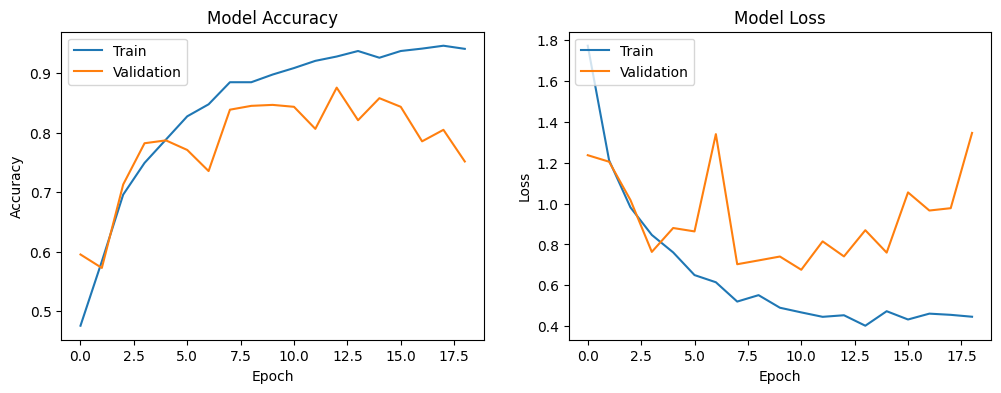

In [8]:
import matplotlib.pyplot as plt
learning_curve(cnn_hist)

In [9]:
# Function to fine-tune applicatoin model
def improved_keras_app_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.1)(x)  # Adjust dropout rate as needed
    predictions = Dense(4, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # Fine-tune optimizer and learning rate
    optimizer = Adam(learning_rate=0.0001)  # Adjust learning rate as needed
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    return model

# Load pre-trained VGG16 model
base_InceptionResNetV2_model = InceptionResNetV2(weights='imagenet', include_top=False, 
                         input_shape=input_shape)

# Fine-tune VGG16 model
# vgg16_model = keras_app_model(base_vgg16_model)
InceptionResNetV2_model = improved_keras_app_model(base_InceptionResNetV2_model)

# Train VGG16 model
InceptionResNetV2_hist = InceptionResNetV2_model.fit(
    train_images, 
    train_labels, 
    epochs=20, 
    batch_size=8, 
    validation_data=(test_images, test_labels),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", 
                                                patience=3, 
                                                restore_best_weights=True)]
)

# Save the model
InceptionResNetV2_model.save('InceptionResNetV2_model.h5')

Epoch 1/20
310/310 [==============================] - 148s 188ms/step - loss: 0.4648 - accuracy: 0.8288 - val_loss: 0.3210 - val_accuracy: 0.9065
Epoch 2/20
310/310 [==============================] - 52s 167ms/step - loss: 0.1746 - accuracy: 0.9370 - val_loss: 0.2300 - val_accuracy: 0.9290
Epoch 3/20
310/310 [==============================] - 52s 167ms/step - loss: 0.0959 - accuracy: 0.9677 - val_loss: 0.1087 - val_accuracy: 0.9645
Epoch 4/20
310/310 [==============================] - 51s 166ms/step - loss: 0.0846 - accuracy: 0.9697 - val_loss: 5.5550 - val_accuracy: 0.9210
Epoch 5/20
310/310 [==============================] - 51s 166ms/step - loss: 0.0560 - accuracy: 0.9810 - val_loss: 1.7980 - val_accuracy: 0.9306
Epoch 6/20
310/310 [==============================] - 52s 167ms/step - loss: 0.0503 - accuracy: 0.9863 - val_loss: 0.2420 - val_accuracy: 0.9419


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [10]:
# Measure test accuracy
scores = InceptionResNetV2_model.evaluate(test_images, test_labels, verbose=0)
print("Test Accuracy: %.2f%%" % (scores[1] * 100))

Test Accuracy: 96.45%


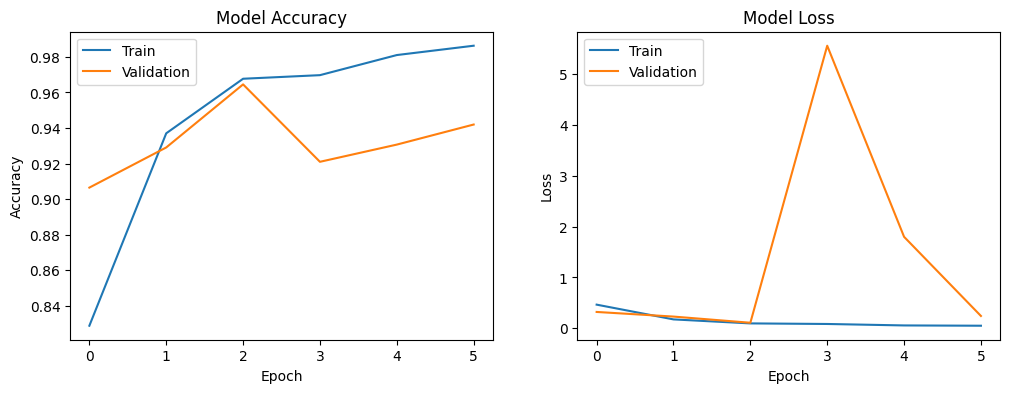

In [11]:
learning_curve(InceptionResNetV2_hist)

In [12]:
# Function to fine-tune applicatoin model
def improved_keras_app_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.1)(x)  # Adjust dropout rate as needed
    predictions = Dense(4, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # Fine-tune optimizer and learning rate
    optimizer = Adam(learning_rate=0.0001)  # Adjust learning rate as needed
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    return model
# Load pre-trained ResNet50 model
base_resnet50_model = ResNet50(weights='imagenet', include_top=False, 
                               input_shape=input_shape)

# Fine-tune ResNet50 model
# resnet50_model = keras_app_model(base_resnet50_model)
resnet50_model = improved_keras_app_model(base_resnet50_model)

# Train ResNet50 model
resnet50_hist = resnet50_model.fit(
    train_images, 
    train_labels, 
    epochs=20, 
    batch_size=8, 
    validation_data=(test_images, test_labels),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", 
                                                patience=3, 
                                                restore_best_weights=True)]
)

# Save the model
resnet50_model.save('resnet50_model.h5')

Epoch 1/20
310/310 [==============================] - 62s 87ms/step - loss: 0.4920 - accuracy: 0.8255 - val_loss: 0.4786 - val_accuracy: 0.8258
Epoch 2/20
310/310 [==============================] - 24s 77ms/step - loss: 0.1861 - accuracy: 0.9398 - val_loss: 0.2573 - val_accuracy: 0.9016
Epoch 3/20
310/310 [==============================] - 24s 77ms/step - loss: 0.0964 - accuracy: 0.9709 - val_loss: 0.4399 - val_accuracy: 0.8903
Epoch 4/20
310/310 [==============================] - 24s 77ms/step - loss: 0.0699 - accuracy: 0.9774 - val_loss: 0.3309 - val_accuracy: 0.9081
Epoch 5/20
310/310 [==============================] - 24s 77ms/step - loss: 0.0737 - accuracy: 0.9742 - val_loss: 0.2837 - val_accuracy: 0.9177
Epoch 6/20
310/310 [==============================] - 24s 76ms/step - loss: 0.0263 - accuracy: 0.9927 - val_loss: 0.3919 - val_accuracy: 0.9000
Epoch 7/20
310/310 [==============================] - 24s 77ms/step - loss: 0.0541 - accuracy: 0.9855 - val_loss: 0.2098 - val_accuracy:

In [13]:
# Measure test accuracy
scores = resnet50_model.evaluate(test_images, test_labels, verbose=0)
print("Test Accuracy: %.2f%%" % (scores[1] * 100))

Test Accuracy: 96.77%


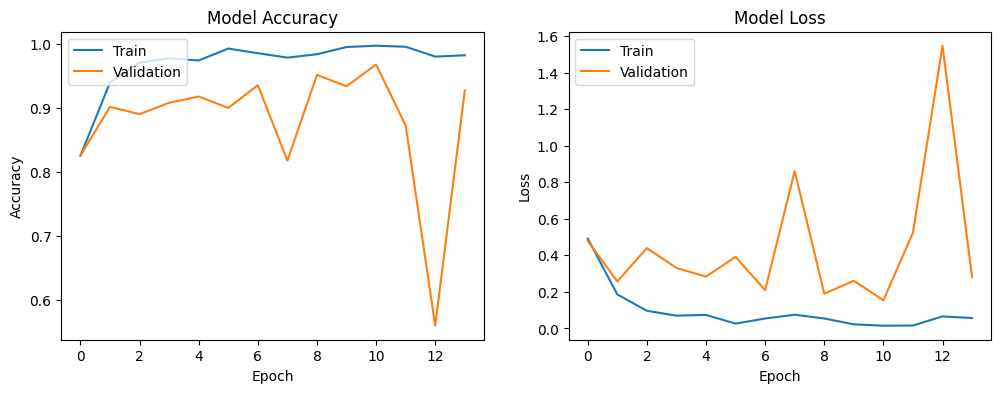

In [14]:
learning_curve(resnet50_hist)

In [15]:
# Make predictions on the validation set
cnn_model_pred = cnn_model.predict(test_images)
resnet50_model_pred = resnet50_model.predict(test_images)
InceptionResNetV2_model_pred = resnet50_model.predict(test_images)

20/20 [==============================] - 1s 67ms/step


In [16]:
# Combine the predictions of the base models into a single feature matrix
X_val_meta = np.column_stack((cnn_model_pred, resnet50_model_pred, 
                              InceptionResNetV2_model_pred))

# Train the meta-model on the combined feature matrix and the target values
meta_model = LinearRegression()
meta_model.fit(X_val_meta, test_labels)

joblib.dump(meta_model, 'stacked_model.joblib')

stacked_predictions = meta_model.predict(X_val_meta)

In [17]:
# Convert predictions to classes (if needed)
stacked_classes = np.round(stacked_predictions).astype(int)

# Evaluate accuracy
accuracy = accuracy_score(test_labels, stacked_classes)
print(f'Accuracy: {accuracy:.2f}')

# Other classification metrics
print(classification_report(test_labels, stacked_classes))


Accuracy: 0.97
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       196
           1       0.96      0.93      0.94       163
           2       0.98      0.99      0.99       186
           3       0.99      1.00      0.99        75

   micro avg       0.97      0.97      0.97       620
   macro avg       0.97      0.97      0.97       620
weighted avg       0.97      0.97      0.97       620
 samples avg       0.97      0.97      0.97       620



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
